# 10 Advanced Computer Vision Applications
> Before Starting, we will change the accelerator of this notebook from a CPU to a GPU, since we'll be running our Neural Networks on the GPU. 

> Go to Runtime --> Change Runtime Type --> GPU 

Welcome to the 10th session in Practical Machine Learning. We discussed about Convolutional Neural Networks and how to use it for fundamental computer vision applications such as classification of images, and got some pretty wonderful results as well. You must have built your own image classifier on your own dataset, using very less lines of code. Let us continue our journey in computer vision. We'll be building some advanced computer vision systems. In this session, we'll be learning about two types of Computer Vision applications - *Object localization* and *Segmentation*.

Object Localization involves identifying where in an image certain objects lie. There are many ways to do this, but an extremely popular way to do this is by bounding boxes. 

![](https://drive.google.com/uc?id=1Ft_d89BCa4SJXzhryQSJKvmSnHkcSj9T)

It is extremely useful in tracking the position and movement of objects. For example, bounding boxes are very widely used in surveillance systems to identify accidents, criminals, or just to ensure that everything is going smoothly. 

Goverments use traffic surveillances systems that use object localization technology to identify which cars pass through a particular location. This not only can be used to automatically fine people who break the traffic rules, but also as an intelligence system that accounts for the whereabouts of a vehicle in case of a criminal activity. It can also be used to identify accidents, without a human operator necessarily searching for such incidents. Thus, a system like this can help reduce burden on the human resources required for efficient monitoring. 

![](https://drive.google.com/uc?id=1HKsH_yKs9L5WrbOBePqsP38fmie02ie6)

Apart from this, it is a key element in the vision system of self-driving cars, that need to identify objects to avoid collisions. 

![](https://drive.google.com/uc?id=1W_jZmPvmVppB6hXBSCsgFTbvVbjfR_tg)

Not only vehicles, even people can be monitored for similar reasons. Many people even install such systems at their homes to detect burglaries. And this is also the technology that is used for facial recognition. While it is a wonderful application, there are also some growing concerns regarding the right to privacy of citizens of a place, when it comes to facial recognition for surveillance systems at places, which may not be completely necessary. 

![](https://drive.google.com/uc?id=1q-dIQvqpdjnIWQgYi3xzHB87dWg-wwn0)

Not just humans or vehicles, localization can be used for specific applications, like keeping track of your cattle if you're a farmer, or to separate different types of trash through a robot at a recycling factory, and so on. 

AI has turned out to be one of the most efficient ways to carry out object localization. A lot of research has been done in this area. A few years ago, it used to be one of the hottest topic in AI research. An algorithm called [YOLO](https://arxiv.org/abs/1506.02640) (*You Only Look Once*) was one such object localization algorithm, the name of which is still very famous, and even after many years, people are working to improve it, even if marginally. Just last year in 2020, the fifth version of YOLO (YOLOv5) was released, which introduced minor changes such as changing the activation function, or the architecture very slightly. 

Lately, however, there has been a decline in the number of publications each year on this topic. Yet, it is still one of the most popular systems deployed in the industry, especially in high end systems such as self driving cars, autonomous robots, surveillance systems. 

Infact, it is such a huge deal, that there are full fledged companies that build software for object localization. Most car manufacturers, that now use computer vision driving aid do not develop their own software, but outsource it. Even Tesla used to outsource its driving assist technologies until a few years ago.

Segmentation is another form of object localization, but with a slightly different approach. The idea is not to create a bounding box around objects, but to create a map of pixels which tell us which pixel belongs to which object. This makes it a somewhat more refined version of object localization and detection. This is what segmentation looks like. 

![](https://drive.google.com/uc?id=1VCqNjLnU5JDvH0MSHfAqf9s5GNssAOCw)

Each pixel is classified into an object. This produces a segmentation map, which you can overlay ontop of the original image to understand where objects are in the image. 

Segmentation helps us better understand the overall image, since every pixel is classified into an object. It is widely used in satellite imagery to understand the different types of land areas, or settlements ir even individual peices of farmlands. Some institutions have been doing some research on using segmentation to classify soil as fertile or infertile based on only satellite imagery and thermal sensors. 

Let us begin by understanding a bounding box prediction system, and then move on to segmentation.

Before anything else, we will begin by installing the necessary libraries.

In [ ]:
%cd

/root


In [ ]:
!pip install --upgrade fastai >./tmp
from fastai.vision.all import *

!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git >./tmp
%cd 'Practical-Deep-Learning-for-Coders-2.0/Computer Vision'
from imports import *
%cd


ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Cloning into 'Practical-Deep-Learning-for-Coders-2.0'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1292 (delta 18), reused 27 (delta 6), pack-reused 1227
Receiving objects: 100% (1292/1292), 86.33 MiB | 35.72 MiB/s, done.
Resolving deltas: 100% (805/805), done.
/root/Practical-Deep-Learning-for-Coders-2.0/Computer Vision
/root


## Bounding Box Object Detection

Our goal is to train a Convolutional Neural Network that can predict not classes, but cordinates of a bounding box. We also want it to predict which object there is inside the box. The latter is a simple image classification task. Once you predict bounding boxes, you can simply pass the area of the image inside the bounding box to an image classidier, and it will give us the class to which the object belongs. The tough part is to predict the bounding boxes. This is in essence a regression proble, where we're trying to predict four pairs of cordinates. 

Before jumping into the model implementation, let us set up the data. There is a dataset called the [PASCAL](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which is a dataset, which provides comprehensive information about the categories, as well as locations in the form of bounding boxes as well as segmentation maps. We are concerned only with the bounding boxes. 

In [ ]:
path=untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/segmentation')]

It is always helpful to analyze the structure of the directory where our data is. There is folder called `train.json`, which contains annotations of bounding boxes of all objects in each image of the training set, present in the `train` directory. These annotations are quite common in many datasets, such as the COCO dataset, or other recent localization datasets, and usually follow a similar structuring internally. Because of this, fasatai provides us with a function called `get_annotations` to retrive these bounding boxes.

In [ ]:
imgs, lbl_bbox = get_annotations(path/'train.json')

In [ ]:
??get_annotations

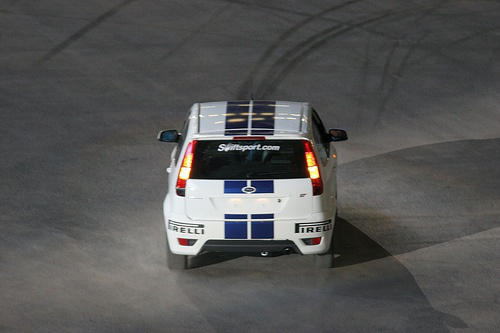

In [ ]:
Image.open(path/f'train/{imgs[0]}')

In [ ]:
lbl_bbox[0] #cordinates and class of the object

([[155, 96, 351, 270]], ['car'])

The dataset (dataloader) would obviously expect the image as well as the annotations together, so let us create a dictionaty that maps each training image.

In [ ]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [ ]:
#ultimately we will be using the fastai API, which uses a function to retreive these images/labels. So we create a function that return this. 
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

*Lessons in Python*

**THe lambda function**

the lambda function is an equivalent to any other function, except that is is very handy when you only have to write a single line of functionality. 

` func = lambda x: res`

is the same as 

```
def func(x):
    return res
```

So lambda function are a great way to help better organize the code. 

This is all we need to create a data. Now all we need to do it so create dataloaders of our data, which we do using the fastai API. You need not memorize each specific component that is used in the API.

In [ ]:
# Don't worry about what a DataBlock is. It is nothing but a way of telling the API - what kind of data we're handling, how to retrieve it, how to split it, what to do with it before training, etc. 
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=lambda x:imgs,
                 getters=getters,
                 item_tfms=[Resize(128, method='pad')],
                 batch_tfms=[Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)],
                 n_inp=1)

In [ ]:
dls = pascal.dataloaders(path/'train')

In [ ]:
#dls.c represents the number of classes in the datasets. Again, you can ignnore it. 
#According to the homepage, there are 20 classes in this dataset. 
dls.c = 20

Let us see what our data looks like.

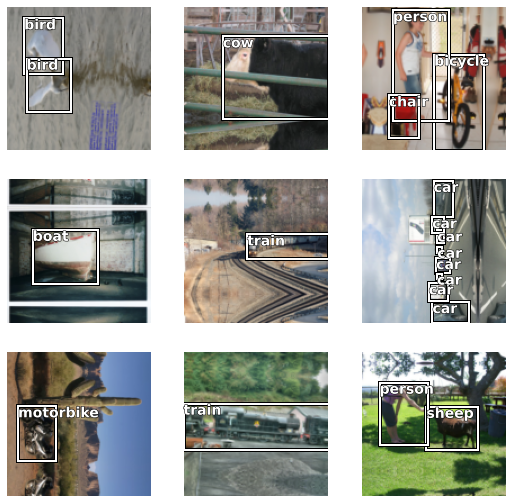

In [ ]:
dls.show_batch()

Now coming to our model. We'll be implementing the [RetinaNet](https://arxiv.org/abs/1708.02002) model. Before proceeding further, you are encouraged to read this paper. The idea behind this exercise is not only to understand the concepts in this paper, but also to learn how to read a research paper (Yes! It's a skill in itself)

You can't read a paper word by word, end to end. Its just way too inefficient. Also, a lot of times, research papers are written only to fill up space. A researcher may only have a page worth of idea, but will try to extend it to 10 pages, so that it looks more impactful to reviewers and readers. So searching for key concepts and ideas within a research paper is a key skill you should gain. Since AI is a field that is constantly evolving, and so fast changing, you *will* have to involve yourself with the latest research in AI in order to keep yourself up-to-date with current trends. 

[This](https://www.youtube.com/watch?v=733m6qBH-jI) is a great video by Andrew Ng at Stanford University showing how to read research papers. Trust us, this one hour or so is a great investment of your time, for all of your future endeavours, especially in AI. 

Coming back to the RetinaNet model, it is a very simple model, that can do 2 tasks sumultaneously - it can 
1. Predict bounding boxes around objects in an image
2. It can simultaneouly predict which class the object belongs to. 

Here's the diagram of the architecture of the RetinaNet model, that the authors used in the research paper. 

![](https://drive.google.com/uc?id=1hFE3mhFWn6geW8r8cwAUuFPE1SS3IdVM)

Can you notice *ResNets* in the model? That is the backbone, or the main element of the model. We already have seen ResNets - they're used for classification. 

Ultimately, ResNets, or CNNs are used *to extract useful features from input data (images)*, which is necessary for any image recognition task. Images themselves are way too complex for models to be understood directly - they have to broken down into *features* to understand what is going on in the picture. Infact, even a complex system such as our brain has to break down visual data from the eyes to more meaningful features for it to understand. Though it is a completely separate issue that we don't exactly know what those features are. 

Any sequential model that is used to derive features is called an *encoder*. To this encoder, additional layers are stacked to get desired results. For example, in this cases, on top of the ResNet based encoder, there are other Convolution Layers (which the authors collectively refer to as a Feature Pyramid Network), which does the task of creating bounding boxes as well as predict the class of the object. 

So first we build the encoder using a standard ResNet architecture with 34 layers, and we use ImageNet pretrained weights to accelerate our training.

In [ ]:
encoder = create_body(resnet34, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Next, there is an inbuilt class called `RetinaNet` in Zach Mueller's github repo, that implements the Feature Pyramid Network. We will however, not implement it from scratch, since there are a lot of advanced python and pytorch concepts that are involved in it, and you do not necessarily need to know the intricate details. However, we will skim through the source code to get a general idea of how the model is built from ground-up.

In [ ]:
arch = RetinaNet(encoder, dls.c, final_bias=-4)

In [ ]:
??RetinaNet #implementation of the whole paper in around 15 lines of code

### Loss function: the Focal Loss
The paper introduces a novel loss function called as the focal loss. You can read about the details in the paper. In total, it is somewhat similar in behaviour to the traditional Cross Entropy loss function that we've seen earlier. However, one objective of the focal loss function is, that it works well even when the categories of data are *skewed*, or imbalanced in number by a huge margin. 

Here is the definition of Cross Entropy Loss function, vs the novel focal loss function.

Cross Entropy loss

![](https://drive.google.com/uc?id=1Rl-LnVHALpK4IVkHTOuSev8vLyyzUfVa)

v/s the Focal Loss

![](https://drive.google.com/uc?id=1x8laGDndOAYFUpBXZdjEIyfBAjcolL8W)

The implementation of the Focal loss is fairly straightforward.

In [ ]:
??RetinaNetFocalLoss #see def _focal_loss

In [ ]:
#These are the hyperparameters of the focal loss class. Try to understand them, through the paper, but if you don't, thats okay!
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [ ]:
#additional functionality for fastai's internal API. As we mentioned before, fastai expects the model in a split modular way, rather than one single big module. This is so that it can efficiently apply hyperparameter schedules to each individual module. 
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

Now, our architecture is ready to be fed for training. As we mentioned, fastai has a `Learner` class, which can be used to train your own model.

In [ ]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)
learn.freeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,3.306251,2.932585,00:37
1,2.885191,2.733445,00:34
2,2.700756,2.567282,00:34
3,2.578294,2.363900,00:34
4,2.488615,2.512094,00:34
5,2.405415,2.354042,00:34
6,2.334568,2.321521,00:34
7,2.278864,2.386318,00:34
8,2.229462,2.303509,00:34
9,2.196646,2.311031,00:34


So, you see how you can train your own Object Localization model. 

Fastai in itself is a very expansive library, and provides a lot of functionality in terms of datasets and models. Sometimes however, not all types of data, models or functionalities are available. Nevertheless, you only need to learn how to set up key elements of the data. For example, fastai provided us with the PASCAL datasets, but with no functionality to set up bounding boxes. So we first had to do that. 

Next, we had to set up a custom model ourselves. We could have used the Cross Entropy Loss, but for the sake of implementing the paper, we implemented the novel loss function introduced by the authors. 

And after that, all procedures of training were the same. 

Don't worry if you don't understand all the details at once. Its natural. Whats ore important is that you understand the broader idea of Object Localization and how it was done! It takes practice, effort and time to understand all these elements. 

Next, we'll be looking at segmentation, a refined version of object localization. Thankfully, fastai provides us with all functionalities required to create segmentation models, so we don't go into a lot of technical details. 

## Segmentation 
This tutorial is directly taken from the fastai documentation. We will go through each step and try to understand what is happening at each line of code. 

As usual, the first task is to set up the data. For this model, we'll be using the [CAMVID](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) dataset, which is a small dataset containing images of streets, with segmentation annotations, called as *masks*. Basically, for a street, which pixel belongs to a building, or a person, or a car, or a bicycle, and so on. 

This is what the dataset looks like...

![](https://drive.google.com/uc?id=1GGHbn1kUyCd7g5czrz1AE3IvNKzPa2cD)

Can you see how each category is color coded with a separate color? A separate color for buildings, a separate colour for cars, a separate color for the roads, a separate color for the footpath.

Once you have a segmentation mask of the entire image, you can overlay this mask on top of the original image to get something like this. These maps are called masks, because they are used to overlay the original image, to produe meaningful interpretations.

![](https://drive.google.com/uc?id=13u7-wbdcWESCeD_5Z-2Lt-JFeEs5T7KP)

In total, there are 32 different classes in this dataset.



In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/images'),Path('/root/.fastai/data/camvid_tiny/labels')]

As a good coding practice, we try to see how the data is organised in our directory, so that we can efficiently access the data. Apparantly, the input images are within the `images` subdirectory, while the segmentation *masks* are within the `labels` directory. For each image in the `images` directory, the corresponding mask has an extra `_P` at the end of the stem of the filename.

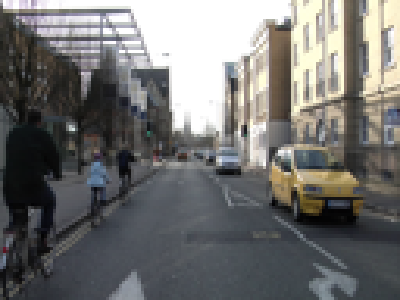

In [ ]:
fnames = get_image_files(path/"images")
Image.open(fnames[0]).reshape(300,400)

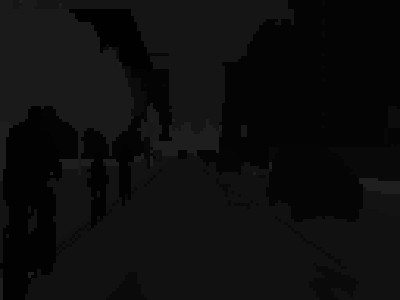

In [ ]:
#just for visualization purpose
Image.open(path/f"labels/{fnames[0].stem}_P.png").reshape(300,400) #this is what a segmentation mask look like. Why is it so dark? because the values are from 0 through 36, and not spread out between pixel values 0 and 255

and the `codes.txt` files contains a mapping of categories. Meaning, which pixel value corresponds to which category.

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
len(codes)

32

As you can see, there are 32 classes in total. 

In [ ]:
#here we're basically defining a function that tells fastai that in order to get the mask for an image, simply append _P to the end of the stem of the filename
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

Now that we've finished setting up the data, we can put them into dataloaders, and visualize what the dataset looks like.

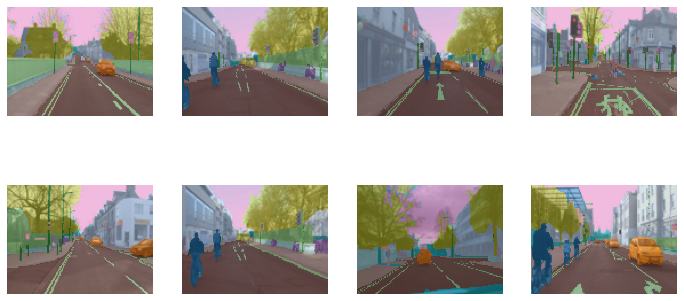

In [ ]:
dls = SegmentationDataLoaders.from_label_func(path, bs=8, fnames = fnames, label_func = label_func, codes = codes)
dls.show_batch()

And now coming to the model.

Segmentation is a slightly different approach towards Computer Vision. It is nothing like we've seen before. All models that we've seen either predict classes out of a finite number of categories, which we call as *classification*, or we've seen models predict values, which we call as *regression*. But here, the model gives an entire image (mask) as the output. How do we design Neural Nets that do that. 

There is a separate class of Convolutional Neural Networks, called as **U-Nets**. UNets [were first introduced](https://arxiv.org/abs/1505.04597) in 2015 for biomedical image segmentation. Initially it was not given much attention by the AI community, but in the past 3 years or so, they have become very famous for segmentation in areas outside of biomedical studies. 


This is what a UNet looks like

![](https://drive.google.com/uc?id=1RESdhDSKaa-wSlVb7wT4O045Z4r5qkaP)

Its called a Unet because it is generally represented as a U-shaped network!

The first half of the network is called an encoder, and the other half (on the right) is called the decoder network.

As we discussed before, encoder is anything that derives features. And we also discussed that our standard CNN, such as a ResNet can do that!

So now you know that the first part is nothing but a ResNet architecture. We feed an image, and get certain features at the end. 

The second half is nothing but the *reverse* of a CNN. The reverse of a convolution is often called as a deconvolution. 

Remember how a convolution over an image, results in a map that is slightly lower in dimensions that the image iteself? A deconvolution does the reverse - it takes in a lower dimension representation, and results in a representation with larger dimensions. 

![](https://drive.google.com/uc?id=1-CGXB7vv8LCMTPPvCaqBrXKyBb0BRzHk)

See, how a 3x3 representation (blue cells) results in a 5x5 representation. This is done by introducing spacings between the "pixels" of the representation, and performing a standard convolution. 

There are also skip connections in between layers, as you can see. This is similar to the ResNet architecture as we've seen. The purpose of these is to retain maximum information, since we likely lose a lot of information at the bottom of the UNet (because we're trying to condense all the information in the input image, to a vector of very less dimension, say only 1024 features). 

So, because of this deconvolutional network, we get an image as an output. We can apply standard Training procedure on this. The idea is the same as before. We have an input (image), and a target (image, in this case, unlike before). This target image need not be the same as the input image. In our case, the raw input image is the input, and the segmentation masks are the output. We wish that the predictions are as close to the target value as possible. So we define a loss function, that measures how different the prediction and target are. Next we use standard Gradient Descent to optimize the model. 

This is a third type of Machine Learning prediction, which I refer to as "Generation". So we slighly change the application domain of Machine Learning now - 

*All of Machine Learning can be condensed into either Classification, Regression, or Generation*.

We will dedicate an entire session on generation. But for now lets study this architecture. 

All classical books on statistics and Machine Learning will tell you, that everything can be condensed into Classification or Regression. However, it makes much more sense to identify Generation as a separate class. This is not meant to conflict with traditional beliefs, but only a proposal from my side to consider while forming your views about Machine Learning in general. The way you look at things has a huge impact on your decisions. So I leave this decision of accepting this idea, upto you!

Let us build this model. Fastai provides with an internal API to handle UNets. All you need to do is tell the API, the encoder is a ResNet34 (say) architecture (you can replace it with another CNN). And it will automatically construct its corresponding *deconvolutional* network. 



In [ ]:
learn = unet_learner(dls, resnet34,metrics=DiceMulti)
learn.fine_tune(10)

epoch,train_loss,valid_loss,dice_multi,time
0,3.333574,2.508930,0.049801,00:04


epoch,train_loss,valid_loss,dice_multi,time
0,2.037020,1.731087,0.093702,00:02
1,1.733720,1.342104,0.112857,00:02
2,1.563287,1.304667,0.112119,00:02
3,1.451086,1.056037,0.143972,00:02
4,1.322891,1.184805,0.151068,00:02
5,1.225772,0.871956,0.181111,00:02
6,1.113357,0.797047,0.191901,00:02
7,1.016650,0.764234,0.196612,00:02
8,0.938331,0.739208,0.200860,00:02
9,0.876159,0.734827,0.202117,00:02


Note that Unets use a slightly different accuracy metric, since we're not dealing with classes anymore. We need to compare how similar two segmnetation masks are. We use the Dice metric, which was introduced in [this](https://arxiv.org/pdf/1911.03347.pdf) paper. The higher the dice metric, the better the model.

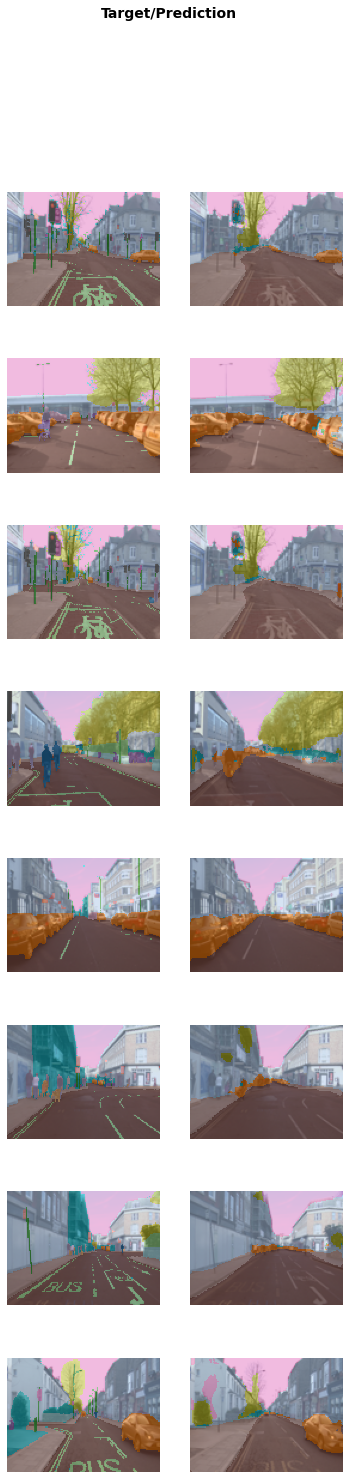

In [ ]:
learn.show_results()

In [ ]:
learn.recorder.values

[(#2) [0.6867644190788269,0.20939201822745865]]

In [ ]:
learn.recorder.values[-1][-1]

0.20939201822745865

Thats it, we've successfuly built our segmentation model. 

## Summary
In this session, we learnt about Object Localization and Segmentation, two of the more advanced computer vision applications. With segmentation, we also looked at a totally new domain of Machine learning applications - Generation! In general, UNets are used whenever we wish to generate an image that is related to the input image. The applications are endless. 

Later on, when we study about Generative Adversarial Networks, the "Generation" version of which also uses a UNet like architecture, we will see how we can use UNets to perform superresolution of blurry images, convert black and white photos to coloured images, bring still photos to life, and much more

## Exercise (Evaluative)

### 1. Exercise 1
This exercise is similar to the exercise in the last session. 
Train the Segmentation model for various models and compare the effect of number of layers on training. Use the same dataset as above.

For this exercise, you will use 3 ResNet variants - 
1. `resnet18`
2. `resnet34`
3. `resnet50`


You dont have to import the model from anywhere, simply type the name of the model during the initialization of the `unet_learner` class.

Plot the accuracies on a graph, and annotate the points with the name of the architecture.

Before you start training, factory reset your runtime, and dont run the cells above this section. Start from this section itself. 

In [1]:
!pip install --upgrade fastai >./tmp
from fastai.vision.all import *

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [2]:
path = untar_data(URLs.CAMVID_TINY)
fnames = get_image_files(path/"images")
codes = np.loadtxt(path/'codes.txt', dtype=str)
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"
dls = SegmentationDataLoaders.from_label_func(path, bs=8, fnames = fnames, label_func = label_func, codes = codes)

In [3]:
models = [resnet18, resnet34, resnet50]
models_string = ["resnet18", "resnet34", "resnet50"]
accuracies = []

In [4]:
for model in models:
  learn = unet_learner(dls, model, metrics=DiceMulti)
  learn.fine_tune(10)
  accuracies.append(learn.recorder.values[-1][-1])
  del learn

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,dice_multi,time
0,2.902373,2.500550,0.045605,00:08


epoch,train_loss,valid_loss,dice_multi,time
0,1.836608,1.453013,0.085862,00:03
1,1.563737,1.226010,0.106940,00:02
2,1.387887,0.975737,0.154010,00:02
3,1.268187,0.961163,0.167846,00:02
4,1.170029,0.808401,0.184944,00:02
5,1.059593,0.716580,0.202632,00:02
6,0.966077,0.696309,0.208401,00:02
7,0.889497,0.683275,0.211836,00:02
8,0.824864,0.660608,0.218640,00:02
9,0.772598,0.656317,0.217174,00:02


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,dice_multi,time
0,2.878005,2.146086,0.057125,00:03


epoch,train_loss,valid_loss,dice_multi,time
0,1.784687,1.416888,0.086765,00:03
1,1.573953,1.284286,0.106415,00:03
2,1.420085,1.148839,0.129823,00:03
3,1.273829,0.906449,0.191329,00:03
4,1.137717,0.764315,0.208804,00:03
5,1.022474,0.681735,0.213292,00:03
6,0.926199,0.684653,0.236443,00:03
7,0.847207,0.648198,0.233975,00:03
8,0.781897,0.642210,0.249336,00:03
9,0.729700,0.641047,0.250167,00:03


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,dice_multi,time
0,3.283334,2.572906,0.025857,00:27


epoch,train_loss,valid_loss,dice_multi,time
0,1.919468,1.511426,0.098569,00:15
1,1.653920,1.237932,0.100691,00:14
2,1.489014,1.100628,0.141013,00:14
3,1.419633,1.169068,0.126506,00:14
4,1.326961,0.917200,0.179838,00:14
5,1.204577,0.761850,0.220985,00:14
6,1.092102,0.702587,0.228612,00:14
7,0.994423,0.642248,0.242885,00:14
8,0.910626,0.625498,0.253205,00:14
9,0.842539,0.620913,0.253761,00:14


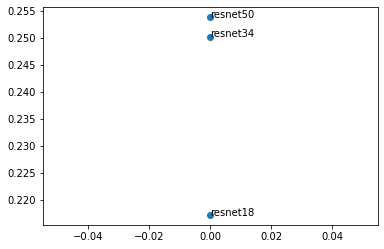

In [6]:
X = [0]*len(models)
Y = accuracies
labels = models_string

for i, (x, y) in zip(labels,(zip(X,Y))):
      plt.annotate(i,xy=(x, y))  
plt.scatter([0]*len(models), accuracies)

plt.show()

You can either use a for loop, or train the models individually. But after each model training, do type `del learn`, so that it clears up the memory. 